# Ćwiczenia 7. Aproksymacja nieliniowa i optymalizacja

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import ast

***Zadanie 1.***

Przygotouj dane pomiarowe znajdujące się w pliku `Raba2015.txt` lub w pliku `Raba2015.txt lepsza wersja` (format zapisu przystosowany do Pythona):
* Dostosuj format danych i umieść je w tablicy NumPy.
* Dane pochodzą z pomiarów przepływu wody ($m^3/s$) w rzece Rabie przeprowadzonych w miejscowości Stróża. Pomiary trwały 68 godzin (od godziny 10:00, 17 listopada 2015 r. do godziny 6:00, 20 listopada 2015 r.).
* Zaprezentuj dane na wykresie.
* Przeprowadź aproskymację przebiegu fali powodziowej za pomocą wielomianu. Wykorzystaj metodę `scipy.optimize.curve_fit`.

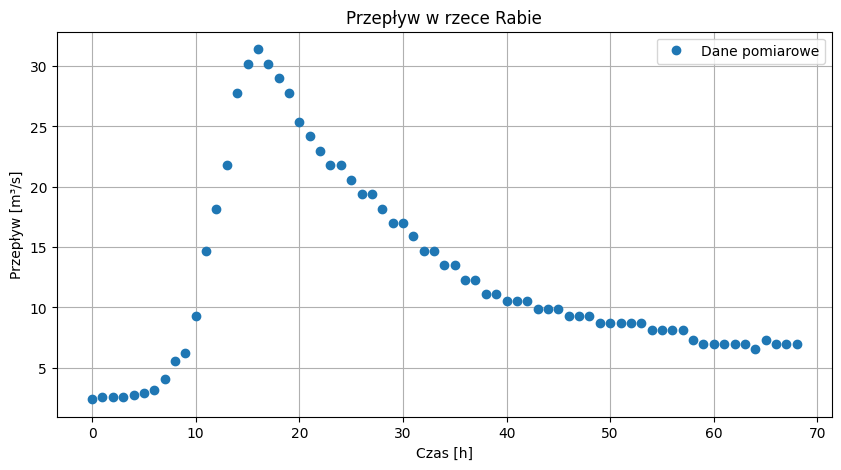

Aproksymacja wielomianowa (stopień 5):
MSE: 10.9860
R²: 0.8144


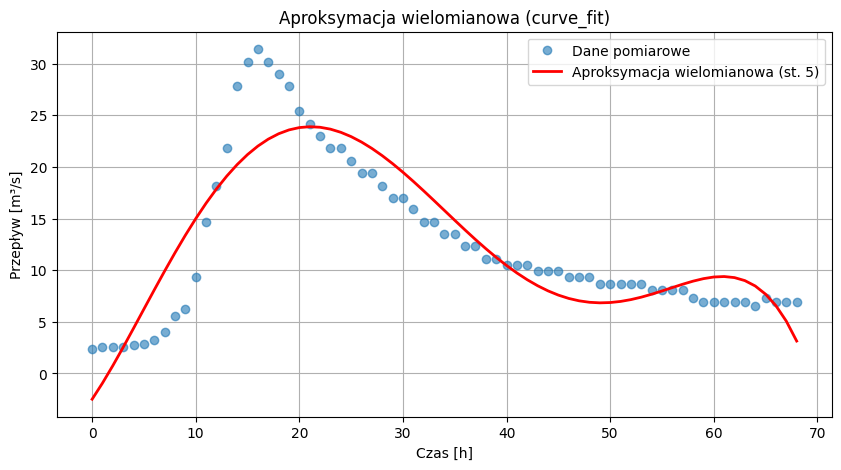

In [ ]:
with open('raba lepsza wersja.txt', 'r') as file: # reads from the file
    content = file.read()
    if "=" in content:
        list_str = content.split("=", 1)[1].strip()
        q = np.array(ast.literal_eval(list_str))
    else:
        q = np.array(ast.literal_eval(content))

hours = np.arange(len(q))

# Plot original data
plt.figure(figsize=(10, 5))
plt.plot(hours, q, 'o', label='Dane pomiarowe')
plt.xlabel('Czas [h]')
plt.ylabel('Przepływ [m³/s]')
plt.title('Przepływ w rzece Rabie')
plt.grid(True)
plt.legend()
plt.show()

# Polynomial approximation using curve_fit
# Defining a 5th degree polynomial: f(x) = a*x^5 + b*x^4 + c*x^3 + d*x^2 + e*x + f
def polynomial_5(x, a, b, c, d, e, f_coeff):
    return a*x**5 + b*x**4 + c*x**3 + d*x**2 + e*x + f_coeff

# Fit the model
p0 = [0, 0, 0, 0, 0, np.mean(q)] # Initial guess
params_poly, _ = scipy.optimize.curve_fit(polynomial_5, hours, q, p0=p0)

# Generate curve
q_poly = polynomial_5(hours, *params_poly)

# Calculate metrics
mse_poly = np.mean((q - q_poly)**2)
r2_poly = 1 - (np.sum((q - q_poly)**2) / np.sum((q - np.mean(q))**2))

print(f"Aproksymacja wielomianowa (stopień 5):")
print(f"MSE: {mse_poly:.4f}")
print(f"R²: {r2_poly:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(hours, q, 'o', label='Dane pomiarowe', alpha=0.6)
plt.plot(hours, q_poly, 'r-', label='Aproksymacja wielomianowa (st. 5)', linewidth=2)
plt.xlabel('Czas [h]')
plt.ylabel('Przepływ [m³/s]')
plt.title('Aproksymacja wielomianowa (curve_fit)')
plt.grid(True)
plt.legend()
plt.show()

***Zadanie 2. Nieliniowa aproksymacja tempa opadu fali powodziowej***

1. Przyjmijmy następujący wskaźnik jakość aproksymacji: $\sum_{i=0}^{n}(F(x_i)-y_i)^2$. Chcemy przeprowadzić aproksymacje fragmentu zbioru danych, który reprezentuje spadek przepływu. 
2. Z a pomocą funkcji `scipy.optimize.minimize` oblicz wartości parametrów funkcji aproksymującej w postaci $f(x) = ce^{−\lambda x}$. Przetestuj różne solvery. Funkcja `minimize` to funkcja znajdująca minimum, a zatem należy do niej przekazać funkcję błędu, której parametrami będą $c$ oraz $\lambda$. Wartości punktów $x$ i $y$ muszą być umieszczone w funkcji błędu, ale nie mogą być jej argumentami.
3. Wykreśl dane oraz funkcję aproksymującą.
4. Oceń jakość aproksymacji.
5. Powyższy eksperyment należy powtórzyć z funkcją aproksymującą o większej liczbie parametrów.
6. Zaproponuj inną funkcji aproksymującej z liniowymi lub nieliniowymi parametrami i przeprowadź aproksymację fali powodziowej.

Model 1: f(x) = c * exp(-lambda * x)
Optimized parameters: c = 29.1059, lambda = 0.0362
Final Error (SSE): 89.0949


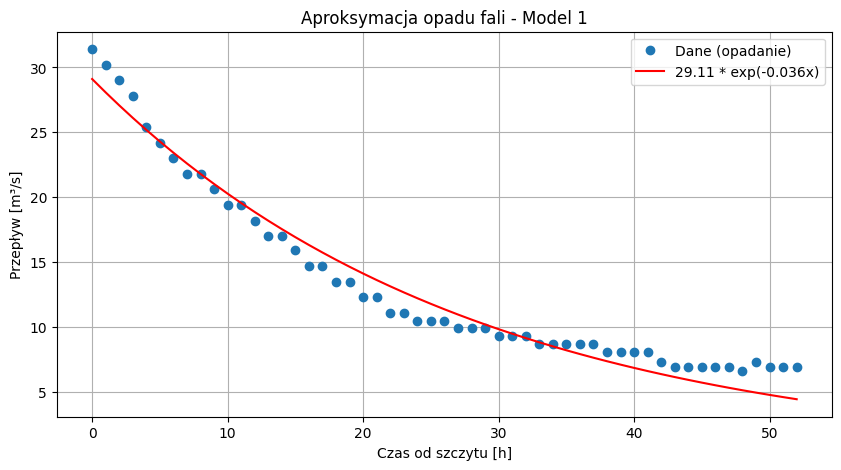

Model 2: f(x) = a * exp(-b * x) + d
Optimized parameters: a=26.0184, b=0.0656, d=5.8547
Final Error (SSE): 8.1771

Model 3: f(x) = a / (x + b) + c
Final Error (SSE): 17.4399


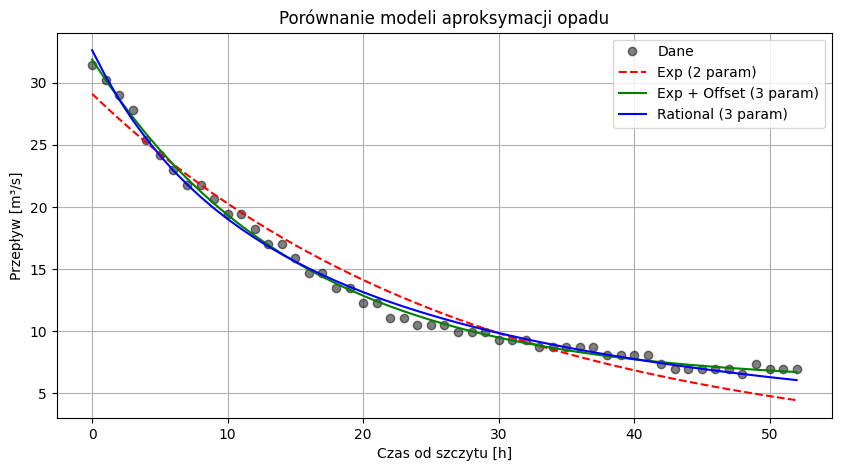

In [17]:
peak_idx = np.argmax(q)
# Shift time so decay starts at t=0 for numerical stability
hours_decay = hours[peak_idx:] - hours[peak_idx] 
q_decay = q[peak_idx:]

# Define the model and error function
def exponential_model(x, c, lam):
    return c * np.exp(-lam * x)
def error_function(params, x_data, y_data):
    c, lam = params
    y_pred = exponential_model(x_data, c, lam)
    return np.sum((y_pred - y_data)**2)

# Optimize using minimize
# Initial guess: c approx max value, lambda approx small positive
x0 = [q_decay[0], 0.1] 

# Using 'Nelder-Mead' as it's robust for simple problems
result = scipy.optimize.minimize(error_function, x0, args=(hours_decay, q_decay), method='Nelder-Mead')

c_opt, lam_opt = result.x
print(f"Model 1: f(x) = c * exp(-lambda * x)")
print(f"Optimized parameters: c = {c_opt:.4f}, lambda = {lam_opt:.4f}")
print(f"Final Error (SSE): {result.fun:.4f}")

# Generate curve
q_pred_1 = exponential_model(hours_decay, c_opt, lam_opt)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(hours_decay, q_decay, 'o', label='Dane (opadanie)')
plt.plot(hours_decay, q_pred_1, 'r-', label=f'{c_opt:.2f} * exp(-{lam_opt:.3f}x)')
plt.xlabel('Czas od szczytu [h]')
plt.ylabel('Przepływ [m³/s]')
plt.title('Aproksymacja opadu fali - Model 1')
plt.legend()
plt.grid(True)
plt.show()

# More parameters: f(x) = a * exp(-b * x) + d
def exponential_offset_model(x, a, b, d):
    return a * np.exp(-b * x) + d

def error_function_3param(params, x_data, y_data):
    a, b, d = params
    y_pred = exponential_offset_model(x_data, a, b, d)
    return np.sum((y_pred - y_data)**2)

x0_3 = [q_decay[0], 0.1, 0]
result_3 = scipy.optimize.minimize(error_function_3param, x0_3, args=(hours_decay, q_decay), method='BFGS')

a_opt_3, b_opt_3, d_opt_3 = result_3.x
q_pred_3 = exponential_offset_model(hours_decay, *result_3.x)

print(f"Model 2: f(x) = a * exp(-b * x) + d")
print(f"Optimized parameters: a={a_opt_3:.4f}, b={b_opt_3:.4f}, d={d_opt_3:.4f}")
print(f"Final Error (SSE): {result_3.fun:.4f}")

# Another function: Rational function f(x) = a / (x + b) + c
# Often used for processes that decay slower than exponential
def rational_model(x, a, b, c):
    return a / (x + b) + c

def error_function_rational(params, x_data, y_data):
    a, b, c = params
    # Avoid division by zero if b is negative and x hits it, but here x >= 0
    # We can add a penalty or just hope the optimizer steers clear
    if np.any(x_data + b == 0): return 1e9
    y_pred = rational_model(x_data, a, b, c)
    return np.sum((y_pred - y_data)**2)

x0_rat = [100, 10, 0]
result_rat = scipy.optimize.minimize(error_function_rational, x0_rat, args=(hours_decay, q_decay), method='Nelder-Mead')

q_pred_rat = rational_model(hours_decay, *result_rat.x)

print(f"\nModel 3: f(x) = a / (x + b) + c")
print(f"Final Error (SSE): {result_rat.fun:.4f}")

# Comparison Plot
plt.figure(figsize=(10, 5))
plt.plot(hours_decay, q_decay, 'ko', label='Dane', alpha=0.5)
plt.plot(hours_decay, q_pred_1, 'r--', label='Exp (2 param)')
plt.plot(hours_decay, q_pred_3, 'g-', label='Exp + Offset (3 param)')
plt.plot(hours_decay, q_pred_rat, 'b-', label='Rational (3 param)')
plt.xlabel('Czas od szczytu [h]')
plt.ylabel('Przepływ [m³/s]')
plt.title('Porównanie modeli aproksymacji opadu')
plt.legend()
plt.grid(True)
plt.show()

***Zadanie 3. Aproksymacja przebiegu w całej dziedzinie pomiaru***


Aproksymacja przepływu w całym zakresie pomiarów:
* Próba z wielomianami wykładniczymi. Czy zwiększanie liczby składników prowadzi do poprawy aproksymacji?
* Algorytm dla aproksymacji funkcjami sklejanymi.

Model 'Surge' (a*t^b*exp(-ct)+d):
MSE: 6.6727
Spline (smoothing s=69):
MSE: 0.9991


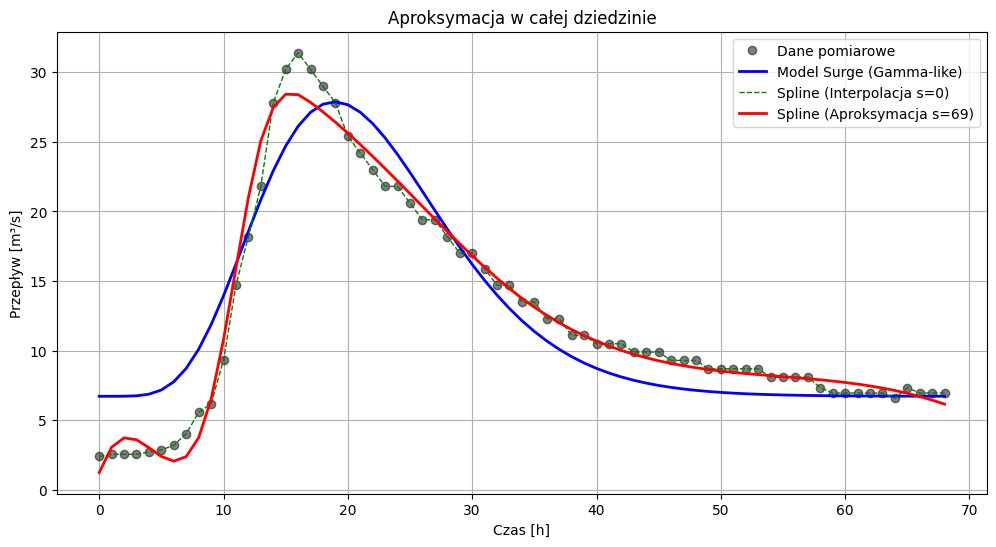

In [18]:
# --- 1. Exponential-Polynomial / Surge Function Approximation ---
# A common model for flood waves is the Gamma function form: f(t) = a * t^b * exp(-c * t)
# Since our data doesn't start at 0 and has a base flow, we might need an offset or shift.
# Let's try a generalized form: f(t) = a * (t)^b * exp(-c * t) + d
# Note: t must be > 0 for the power term if b is not integer.

def surge_model(t, a, b, c, d):
    # Add a small epsilon to t to avoid 0^negative if b < 0 (though b should be > 0)
    # and to allow t=0 if b>0.
    t_safe = t + 1e-5 
    return a * (t_safe**b) * np.exp(-c * t_safe) + d

# Initial guess
# a: scale, b: shape (controls rise), c: decay rate, d: base flow
p0_surge = [10, 2, 0.1, np.min(q)]

try:
    params_surge, _ = scipy.optimize.curve_fit(surge_model, hours, q, p0=p0_surge, maxfev=10000)
    q_surge = surge_model(hours, *params_surge)
    
    mse_surge = np.mean((q - q_surge)**2)
    print(f"Model 'Surge' (a*t^b*exp(-ct)+d):")
    print(f"MSE: {mse_surge:.4f}")
except Exception as e:
    print(f"Surge model fit failed: {e}")
    q_surge = np.zeros_like(q)

# --- 2. Spline Approximation ---
from scipy.interpolate import UnivariateSpline

# UnivariateSpline with smoothing factor s
# s=0 forces interpolation (passes through all points)
# s>0 allows smoothing (approximation)
spline_interp = UnivariateSpline(hours, q, s=0) # Interpolation
spline_smooth = UnivariateSpline(hours, q, s=len(q)) # Smoothing (s approx N is a good start)

q_spline_interp = spline_interp(hours)
q_spline_smooth = spline_smooth(hours)

mse_spline = np.mean((q - q_spline_smooth)**2)
print(f"Spline (smoothing s={len(q)}):")
print(f"MSE: {mse_spline:.4f}")

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(hours, q, 'ko', label='Dane pomiarowe', alpha=0.5)
if np.any(q_surge):
    plt.plot(hours, q_surge, 'b-', label='Model Surge (Gamma-like)', linewidth=2)
plt.plot(hours, q_spline_interp, 'g--', label='Spline (Interpolacja s=0)', linewidth=1)
plt.plot(hours, q_spline_smooth, 'r-', label=f'Spline (Aproksymacja s={len(q)})', linewidth=2)

plt.xlabel('Czas [h]')
plt.ylabel('Przepływ [m³/s]')
plt.title('Aproksymacja w całej dziedzinie')
plt.legend()
plt.grid(True)
plt.show()